In [57]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [58]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../runtime-factor"):
    for name in dirs:
        directories.append(os.path.join(root, name))

for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        factor = directory.split("/")[-1]
        scenario = "explodingLiquid"

        with open(os.path.join(directory, file)) as f:
            print(directory, file)
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not factor in data[scenario]:
            data[scenario][factor] = {}

        data[scenario][factor][file_type] = df_tuners

Processing AutoPas_iterationPerformance_Rank0_2024-11-03_01-54-28.csv
../runtime-factor/5 AutoPas_iterationPerformance_Rank0_2024-11-03_01-54-28.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-11-03_01-54-28.csv
../runtime-factor/5 AutoPas_liveInfoLogger_Rank0_2024-11-03_01-54-28.csv
Processing AutoPas_tuningResults_Rank0_2024-11-03_01-54-28.csv
../runtime-factor/5 AutoPas_tuningResults_Rank0_2024-11-03_01-54-28.csv
Processing AutoPas_tuningData_Rank0_2024-11-03_01-54-28.csv
../runtime-factor/5 AutoPas_tuningData_Rank0_2024-11-03_01-54-28.csv
Processing AutoPas_tuningResults_Rank0_2024-11-03_00-49-39.csv
../runtime-factor/1.5 AutoPas_tuningResults_Rank0_2024-11-03_00-49-39.csv
Processing AutoPas_iterationPerformance_Rank0_2024-11-03_00-49-39.csv
../runtime-factor/1.5 AutoPas_iterationPerformance_Rank0_2024-11-03_00-49-39.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-11-03_00-49-39.csv
../runtime-factor/1.5 AutoPas_liveInfoLogger_Rank0_2024-11-03_00-49-39.csv
Processing AutoPas_tuni

# Make Line Plot of Smoothed Value over Iterations


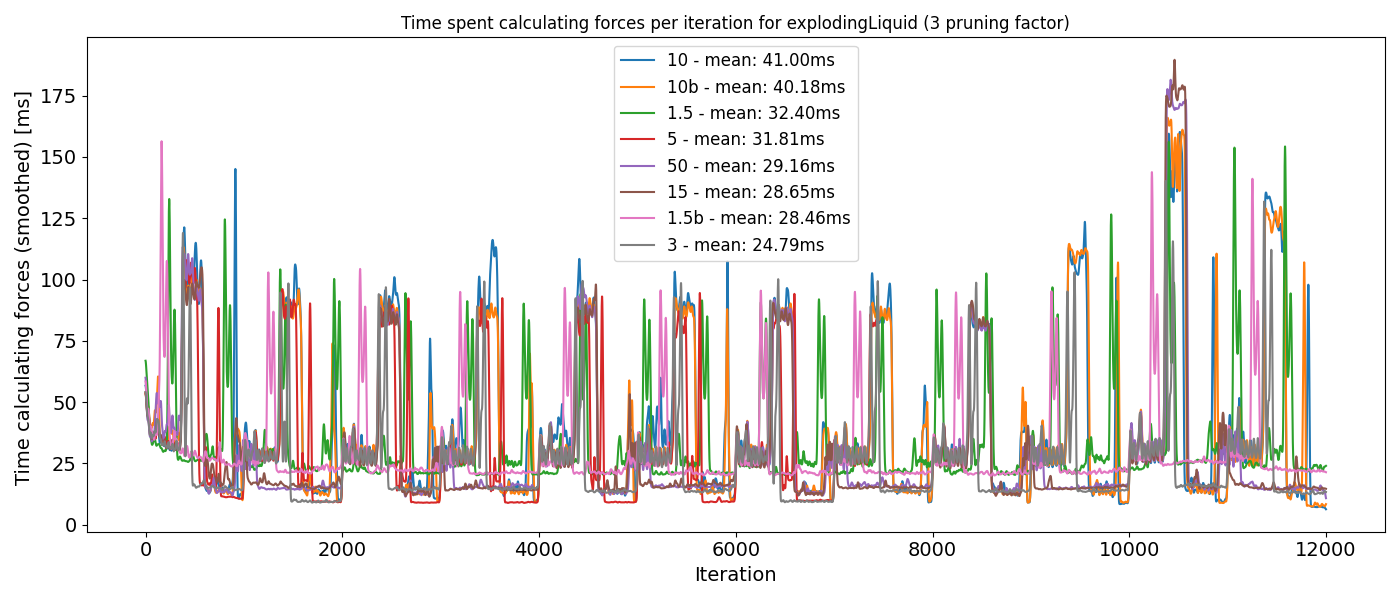

In [59]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    for factor, logs in sorted(s_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):


        iteration_data = logs["iterationPerformance"]

        time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

        first_k = 1000000

        x = iteration_data["Iteration"][:first_k]
        y = time_s[:first_k] * 1000

        mean = y.mean()

        # ax.plot(x, y, label=f"{tuning_algorithm} - mean: {meanNS:.2f}ns")

        if np.logical_or(np.isnan(y), np.isinf(y)).any():
            print(y)
            raise ValueError(f"Found NaN or Inf in {factor}")

        smoother = ConvolutionSmoother(
            window_len=40, window_type='blackman')
        smoother.smooth(y)
        low, up = smoother.get_intervals('sigma_interval', n_sigma=0.04)

        # linewidth = 2.5 if "Fuzzy" in tuning_algorithm else 1
        # opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8
        # linestyle = "-" if "Fuzzy" in tuning_algorithm else ":"

        # color = ax._get_lines.get_next_color()
        # if "Suitability" in tuning_algorithm:
        #     color = "orangered"
        # elif "Components" in tuning_algorithm:
        #     color = "royalblue"

        # if "Holdout" in tuning_algorithm:
        #     linestyle = "--"

        ax.plot(smoother.smooth_data[0], label=f"{
                factor} - mean: {mean:.2f}ms")

        plt.grid()

    ax.legend(prop={'size': 12})
    ax.set_xlabel("Iteration")
    ax.set_ylabel(
        "Time calculating forces (smoothed) [ms] ")

    # ax.set_xlim(0, 12000)

    # set y axis to mikro seconds

    ax.set_title(f"Time spent calculating forces per iteration for {
                    scenario} ({factor} pruning factor)")
    # ax.set_xlim(0, df["Iteration"].max())
    # log

    # make y axis bigger
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    # make axis title bigger
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)

    fig.tight_layout()

    #logarithmic scale
    # ax.set_yscale('log')

    plt.show()
    fig.savefig(f"timing_{scenario}_{factor}.png", dpi=300)

# Make bar plots about total time

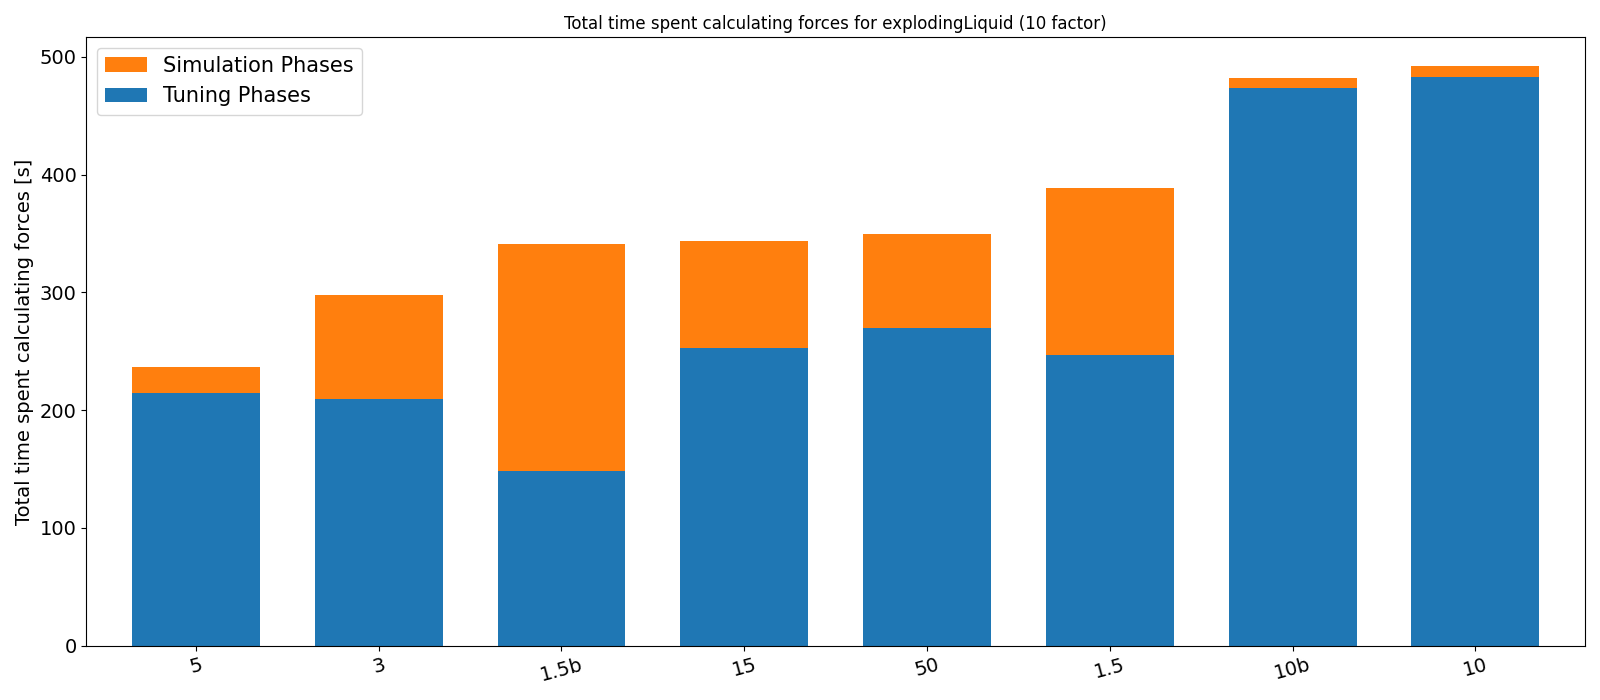

In [60]:
for scenario, s_data in data.items():
    for factor, logs in sorted(s_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):
        longest_simulation = len(logs["iterationPerformance"])


for scenario, s_data in data.items():
    timings = {}
    for factor, logs in sorted(s_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() , reverse=False):

        # filter logs only include where intuningphase is true
        iteration_data = logs["iterationPerformance"]

        tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
        simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

        tuning_time_s = tuning_iterations["iteratePairwiseTotal[ns]"].sum(
        ) / 1e9
        simulation_time_s = simulation_iterations["iteratePairwiseTotal[ns]"].sum(
        ) / 1e9

        timings[factor] = {
            "Tuning Phases": tuning_time_s,
            "Simulation Phases": simulation_time_s
        }


fig, ax = plt.subplots(1, 1, figsize=(16, 7))

# df with tuning algorithm as row
df = pd.DataFrame(timings).T

df.plot(kind='bar', stacked=True, ax=ax, width=0.7)

# tilt x labels
plt.xticks(rotation=15, fontsize=16)

ax.set_ylabel("Total time spent calculating forces [s]", fontsize=16)

ax.set_title(f"Total time spent calculating forces for {
                scenario} ({factor} factor)")

handles, lables = ax.get_legend_handles_labels()
ax.legend(handles[::-1], lables[::-1], prop={'size': 15})

# make y axis bigger
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
# make axis title bigger
ax.yaxis.label.set_size(14)

fig.tight_layout()

#logarithmic scale

fig.savefig(f"total_time_{scenario}_{factor}.png", dpi=300)

In [61]:
# Function to add jittered points
def add_jittered_points(data, pos, color, alpha=0.2, vert=True):
    y = data
    x = np.random.normal(pos, 0.1, size=len(y))

    if vert:
        plt.scatter(x, y, color=color, alpha=alpha)
    else:
        plt.scatter(y, x, color=color, alpha=alpha)

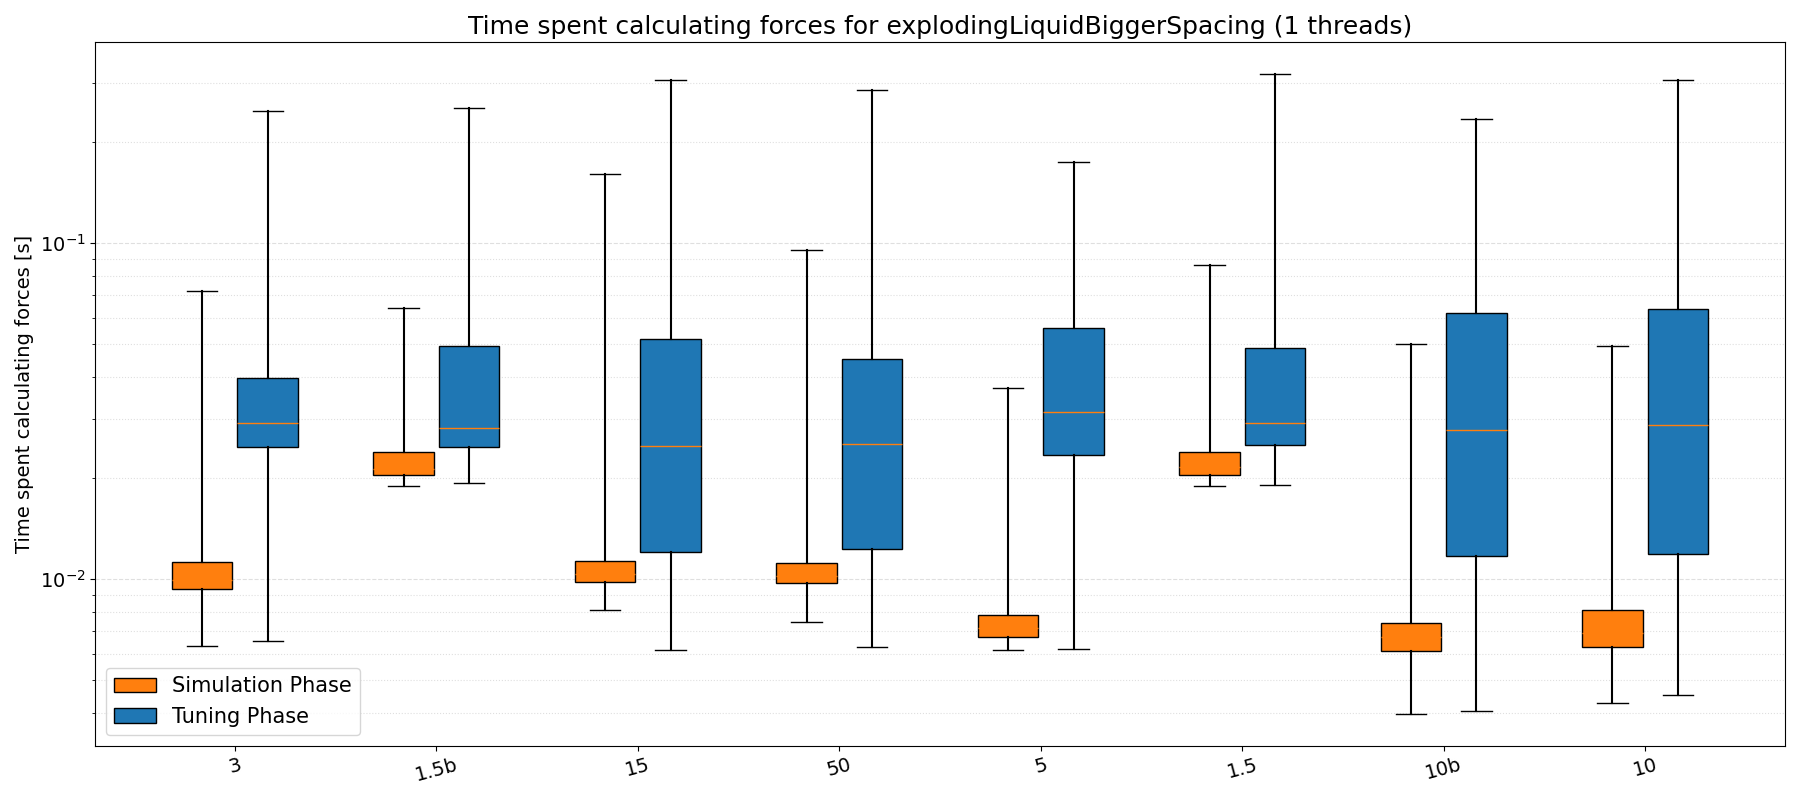

In [62]:
for scenario, s_data in data.items():
    timings = {}
    factors = []
    for factor, logs in sorted(s_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):

        # Collect data
        iteration_data = logs["iterationPerformance"]
        tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
        simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

        factors.append(factor)
        timings[factor] = {
            "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"] / 1e9,
            "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"] / 1e9
        }
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 8))

    # Set positions for boxplots
    # Increased spacing between algorithm groups
    positions = range(0, len(factors) * 4, 4)
    width = 1.2  # Increased width of boxes

    # Create boxplots with jittered outliers
    bp_tuning = ax.boxplot([timings[alg]["Tuning Phases"] for alg in factors],
                           positions=[p + width/2+0.05 for p in positions],
                           widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5), whis=10000)

    bp_simulation = ax.boxplot([timings[alg]["Simulation Phases"] for alg in factors],
                               positions=[p - width/2 -
                                          0.05 for p in positions],
                               widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5), whis=10000)

    # Add scatter plots
    # for i, alg in enumerate(algorithms):
    #     add_jittered_points(
    #         timings[alg]["Tuning Phases"], positions[i] - width/2, '#3498db')
    #     add_jittered_points(
    #         timings[alg]["Simulation Phases"], positions[i] + width/2, '#e67e22')

    # Increase font sizes
    plt.title(
        'Time spent calculating forces for explodingLiquidBiggerSpacing (1 threads)', fontsize=18)
    ax.set_ylabel('Time spent calculating forces [s]', fontsize=16)

    # Rotate x-axis labels
    plt.xticks(rotation=15, fontsize=14)
    plt.yticks(fontsize=14)

    # Use more distinct colors
    for box in bp_tuning['boxes']:
        box.set(facecolor='#1f77b4')
    for box in bp_simulation['boxes']:
        box.set(facecolor='#ff7f0e')  # Orange

    # make whiskers bold
    for whisker in bp_tuning['whiskers']:
        whisker.set_linewidth(1.5)
    for whisker in bp_simulation['whiskers']:
        whisker.set_linewidth(1.5)

    ax.set_xticks(positions)
    ax.set_xticklabels(factors, rotation=15)

    # minor grid lines on y
    ax.yaxis.grid(True, linestyle=':', which='minor',
                  color='grey', alpha=.25)

    # Add legend
    ax.legend([bp_simulation["boxes"][0], bp_tuning["boxes"][0]],
              ["Simulation Phase", "Tuning Phase"], fontsize=15)

    # Logarithmic y-axis
    ax.set_yscale('log')

    # more grid lines
    ax.yaxis.grid(True, linestyle='--', which='major',
                  color='grey', alpha=.25)

    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    # make axis title bigger
    ax.yaxis.label.set_size(14)

    fig.tight_layout()

    fig.savefig(f"boxplot_{scenario}_{factor}.png", dpi=300)

    plt.show()

In [63]:
# Function to add jittered points
def add_jittered_points(data, pos, color, alpha=0.2, vert=True):
    y = data
    x = np.random.normal(pos, 0.1, size=len(y))

    if vert:
        plt.scatter(x, y, color=color, alpha=alpha)
    else:
        plt.scatter(y, x, color=color, alpha=alpha)


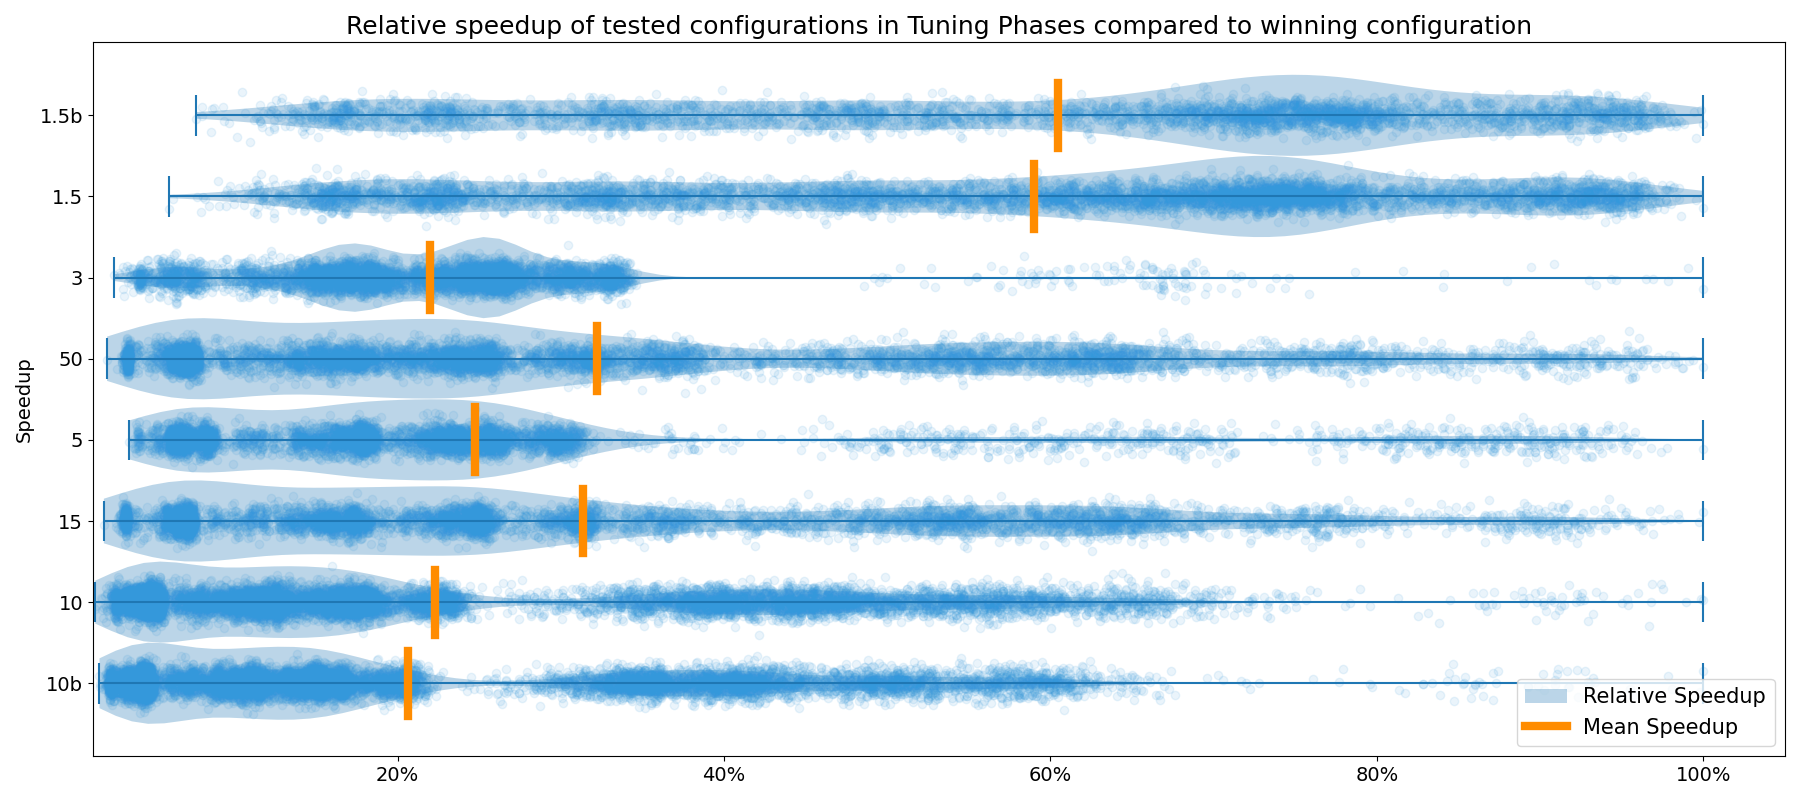

In [64]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
import numpy as np


for scenario, s_data in data.items():
    min_speedup = 1
    speedups = {}
    factors = []
    for factor, logs in sorted(s_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].min(), reverse=False):

        def calc_speedup(x): return x.min() / x

    # Collect data, sort by lowest speedup for tuning phase
        factors.append(factor)
        iteration_data = logs["iterationPerformance"]
        tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]

        speedups[factor] = {
            "Speedup": calc_speedup(tuning_iterations["iteratePairwiseTotal[ns]"])
        }

        min_speedup = min(
            min_speedup, speedups[factor]["Speedup"].min())

    fig, ax = plt.subplots(figsize=(18, 8))

    positions = range(0, len(factors))
    width = 1  # Increased width of boxes

    bp_tuning = ax.violinplot([speedups[alg]["Speedup"]
                               for alg in factors],
                              positions=[p for p in positions],
                              widths=width, vert=False)

    for i, alg in enumerate(factors):
        add_jittered_points(
            speedups[alg]["Speedup"], positions[i], '#3498db', vert=False, alpha=0.1)
    # add median lines
    for i, alg in enumerate(factors):
        mean = speedups[alg]["Speedup"].mean()
        ax.plot([mean, mean], [positions[i] - 0.4, positions[i] + 0.4],
                color='darkorange', linewidth=6)

    # Increase font sizes
    plt.title(
        'Relative speedup of tested configurations in Tuning Phases compared to winning configuration', fontsize=18)
    ax.set_ylabel('Speedup', fontsize=16)

    # Rotate x-axis labels

    # Use more distinct colors
    for box in bp_tuning['bodies']:
        box.set(facecolor='#1f77b4')

    ax.set_yticks(positions)

    ax.set_yticklabels(factors)

    # minor grid lines on y
    ax.yaxis.grid(True, linestyle=':', which='minor',
                  color='grey', alpha=.25)

    # Add legend
    ax.legend([bp_tuning["bodies"][0], Line2D([0], [0], color='darkorange', lw=6)],
              ["Relative Speedup", "Mean Speedup"], fontsize=15)

    # Logarithmic y-axis
    # ax.set_xscale('log')

    # more grid lines
    ax.xaxis.grid(True, linestyle='--', which='minor',
                  color='grey', alpha=.25)

    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    # make axis title bigger

    ax.yaxis.label.set_size(14)

    fig.tight_layout()

    # limit x axis to 1

    ax.set_xlim(min_speedup*0.9, 1.05)
    # y label percent
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

    fig.savefig(
        f"tuning_phase_speedup_{scenario}_{factor}_zoomed.png", dpi=300)

/tmp/ipykernel_116332/89585737.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)


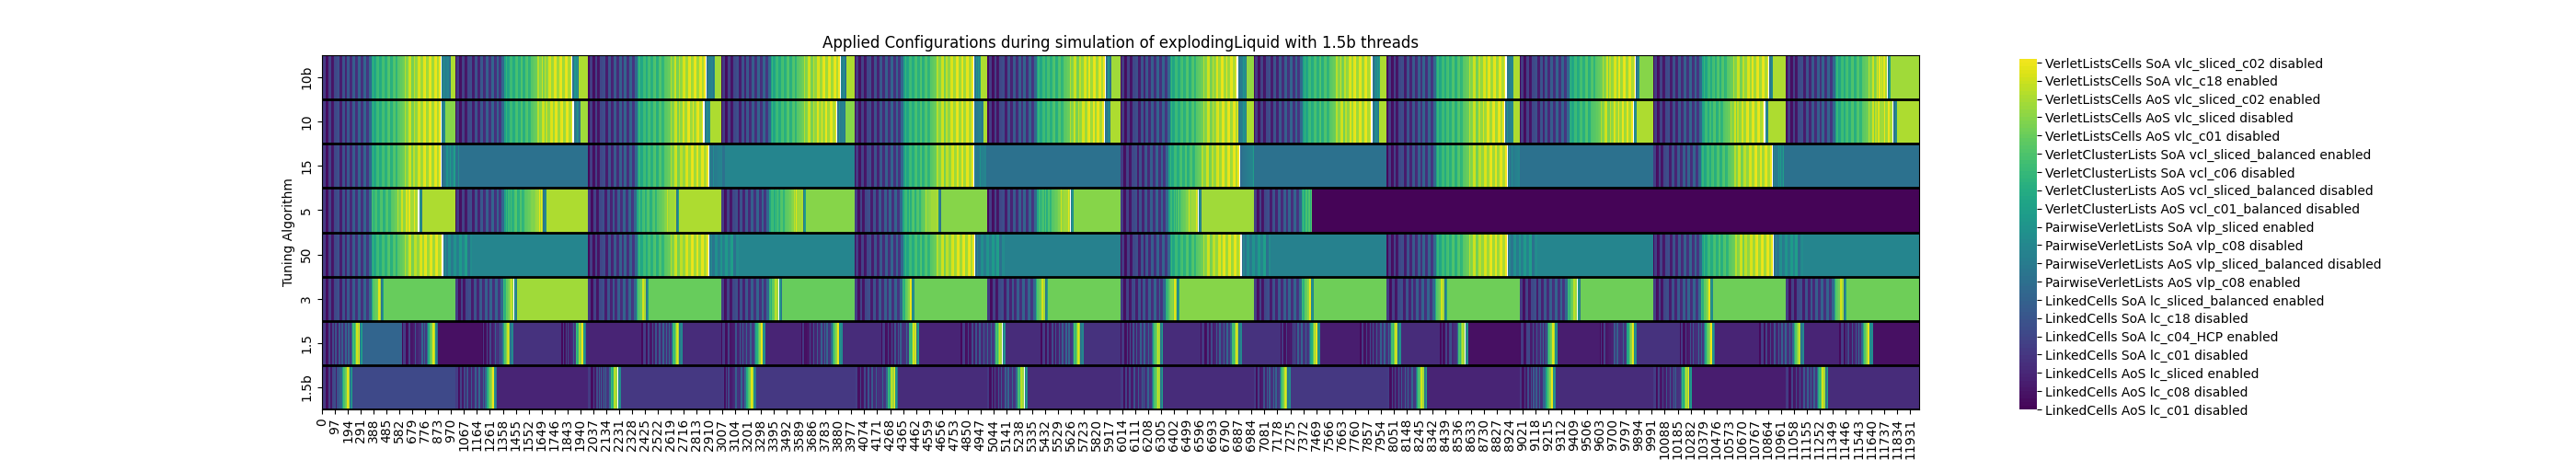

In [65]:
import numpy as np
# TODO FIX THIS. THE ITERATION IS NOT CORRECTLY ALIGNED

for scenario, s_data in data.items():
    df_tuners = pd.DataFrame()

    fig, ax = plt.subplots(1, 1, figsize=(28, 5))

    for factor, logs in sorted(s_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].min(), reverse=False):
        tuning_results = logs["iterationPerformance"]

        iteration = tuning_results["Iteration"]
        container = tuning_results["Container"]
        datalayout = tuning_results["Data Layout"]
        traversal = tuning_results["Traversal"]
        newton3 = tuning_results["Newton 3"]

        combined = []
        for (i, iter) in iteration.items():

            comb = " ".join(
                [str(container.iloc[i]), str(datalayout.iloc[i]), str(traversal.iloc[i]), str(newton3.iloc[i])])
            combined.append(comb)

        total_config = pd.DataFrame(
            combined, columns=[factor])

        df_tuners = pd.concat([df_tuners, total_config], axis=1)

    df = df_tuners

    # find nan values
    # replace nan values with "None"
    df = df.fillna("zzzzNone")

    value_to_int = {value: i for i, value in enumerate(
        sorted(pd.unique(df.values.ravel())))}
    value_to_int["zzzzNone"] = -1

    n = len(value_to_int)
    cmap = sns.color_palette("viridis", n)

    # color zzzzNone with white
    cmap[value_to_int["zzzzNone"]] = (1, 1, 1, 1)

    sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)

    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin

    # only show every k tick
    k = 5

    colorbar.set_ticks(
        [colorbar.vmin + r / (n-1) * i for i in range(0, n, k)])

    colorbar.set_ticklabels(
        [list(value_to_int.keys())[i] for i in range(0, n, k)])

    # legend below the heatmap

    ax.set_title(
        f"Applied Configurations during simulation of {scenario} with {factor} threads")
    ax.set_xlabel("Tuning Phase")
    ax.set_ylabel("Tuning Algorithm")

    # change x ticks to 2000 steps

    # set y label positon to the top left corner

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # set rotation of y labels
    # move y ticks a bit to the left

    # draw horizontal lines
    for i in range(1, len(df.index)):
        ax.axhline(i, color="black", lw=2)

    plt.show()

    plt.savefig(f"colorbar_{scenario}_{factor}.png", dpi=300)

    # fig.savefig(f"heatmap_{scenario}_{thread}.png", dpi=300)